In [1]:
# when ran on colab
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379366 sha256=fdbdd157ca3dd89e64765d52c6cea4b0c816c3d701be72d42ef2075763216271
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [1]:
import gymnasium as gym # type: ignore
import numpy as np # type: ignore
from collections import deque
import random
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import torch.nn.functional as F # type: ignore
import pickle
import time

import matplotlib.pyplot as plt # type: ignore
import cv2 # type: ignore

from collections import deque, namedtuple
import imageio # type: ignore


torch.backends.cudnn.benchmark = True


BATCH_SIZE = 64


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")





## pre-processing

In [2]:

def preprocess(obs):

    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84))
    return resized.astype(np.float32) / 255.0

class FrameStack:

    def __init__(self, k):

        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self, obs):

        pre = preprocess(obs)
        for _ in range(self.k):
            self.frames.append(pre)
        return np.stack(self.frames, axis=0)

    def step(self, obs):

        self.frames.append(preprocess(obs))
        return np.stack(self.frames, axis=0)


class ReplayBuffer:

    def __init__(self, size):

        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)


        return (
            torch.from_numpy(np.array(states)).float().to(DEVICE),
            torch.from_numpy(np.array(actions)).float().to(DEVICE),
            torch.FloatTensor(rewards).unsqueeze(1).to(DEVICE),
            torch.from_numpy(np.array(next_states)).float().to(DEVICE),
            torch.FloatTensor(dones).unsqueeze(1).to(DEVICE)
              )




## actor and critic

In [3]:

class Actor(nn.Module):

    def __init__(self, action_dim):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(3136, 256), nn.ReLU()
        )
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

    def forward(self, state):

        x = self.conv(state).view(state.size(0), -1)
        x = self.fc(x)
        mean = self.mean(x)
        log_std = self.log_std(x).clamp(-20, 2)
        std = torch.exp(log_std)
        return mean, std

    def sample(self, state):

        mean, std = self.forward(state)
        dist = torch.distributions.Normal(mean, std)
        z = dist.rsample()
        action = torch.tanh(z)
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        return action, log_prob.sum(dim=1, keepdim=True)


class Critic(nn.Module):

    def __init__(self, action_dim):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(3136 + action_dim, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):

        x = self.conv(state).view(state.size(0), -1)
        x = torch.cat([x, action], dim=1)
        return self.fc(x)

## defining agent

In [4]:

class sac_agent:

    def __init__(self, env):

        self.env = env
        self.action_dim = env.action_space.shape[0]
        self.replay_buffer = ReplayBuffer(100000)

        self.actor = Actor(self.action_dim).to(DEVICE)
        self.critic1 = Critic(self.action_dim).to(DEVICE)
        self.critic2 = Critic(self.action_dim).to(DEVICE)
        self.target1 = Critic(self.action_dim).to(DEVICE)
        self.target2 = Critic(self.action_dim).to(DEVICE)

        self.target1.load_state_dict(self.critic1.state_dict())
        self.target2.load_state_dict(self.critic2.state_dict())

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic1_opt = optim.Adam(self.critic1.parameters(), lr=1e-4)
        self.critic2_opt = optim.Adam(self.critic2.parameters(), lr=1e-4)

    def select_action(self, state):

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            action, _ = self.actor.sample(state_tensor)
        return action.cpu().numpy()[0]

    def update(self):

        if len(self.replay_buffer) < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)

        with torch.no_grad():

            next_actions, next_log_probs = self.actor.sample(next_states)
            q1_next = self.target1(next_states, next_actions)
            q2_next = self.target2(next_states, next_actions)
            q_target = rewards + 0.99 * (1 - dones) * (torch.min(q1_next, q2_next) - 0.2 * next_log_probs)

        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)

        critic1_loss = F.mse_loss(q1, q_target)
        critic2_loss = F.mse_loss(q2, q_target)

        self.critic1_opt.zero_grad()
        critic1_loss.backward()
        self.critic1_opt.step()

        self.critic2_opt.zero_grad()
        critic2_loss.backward()
        self.critic2_opt.step()

        new_actions, log_probs = self.actor.sample(states)

        actor_loss = (0.2 * log_probs - torch.min(
            self.critic1(states, new_actions),
            self.critic2(states, new_actions)
        )).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()


        for target_param, param in zip(self.target1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(0.005 * param.data + (1 - 0.005) * target_param.data)

        for target_param, param in zip(self.target2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(0.005 * param.data + (1 - 0.005) * target_param.data)

    def train(self, episodes=1000):

        frames = FrameStack(4)
        reward_log = []

        for ep in range(episodes):

            obs, infoi = self.env.reset()
            state = frames.reset(obs)
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = frames.step(next_obs)

                self.replay_buffer.add(state, action, reward, next_state, done)
                self.update()
                state = next_state
                total_reward += reward

            reward_log.append(total_reward)
            print(f"episode {ep+1} | reward: {total_reward:.2f} | timestamp: {time.strftime('%H:%M:%S')}")



        # torch.save(self.actor.state_dict(), "sac.pt")

            best_reward = 0.00

            if total_reward > best_reward:

                best_reward = total_reward
                torch.save(self.actor.state_dict(), "sac.pt")

        return reward_log

## training the agent

episode 1 | reward: -63.33 | timestamp: 23:46:39
episode 2 | reward: -52.54 | timestamp: 23:47:14
episode 3 | reward: -55.13 | timestamp: 23:47:47
episode 4 | reward: -38.86 | timestamp: 23:48:21
episode 5 | reward: -45.05 | timestamp: 23:48:55
episode 6 | reward: -43.66 | timestamp: 23:49:29
episode 7 | reward: -59.25 | timestamp: 23:50:03
episode 8 | reward: -53.64 | timestamp: 23:50:37
episode 9 | reward: -48.53 | timestamp: 23:51:11
episode 10 | reward: -51.72 | timestamp: 23:51:46
episode 11 | reward: -57.19 | timestamp: 23:52:20
episode 12 | reward: -44.25 | timestamp: 23:52:54
episode 13 | reward: -51.14 | timestamp: 23:53:29
episode 14 | reward: -49.82 | timestamp: 23:54:03
episode 15 | reward: -42.31 | timestamp: 23:54:37
episode 16 | reward: -54.25 | timestamp: 23:55:11
episode 17 | reward: -41.63 | timestamp: 23:55:45
episode 18 | reward: -51.52 | timestamp: 23:56:19
episode 19 | reward: -40.52 | timestamp: 23:56:54
episode 20 | reward: -54.82 | timestamp: 23:57:24
episode 2

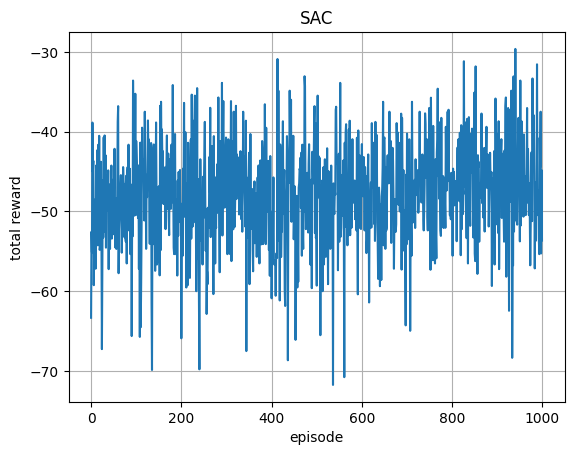

In [4]:


env = gym.make("CarRacing-v3", render_mode=None)
agent = sac_agent(env)
rewards = agent.train()

plt.plot(rewards)
plt.xlabel("episode")
plt.ylabel("total reward")
plt.title("SAC")
plt.grid(True)
plt.show()


## Didnt do agent evaluation and saving a single run, because the I couldnt able to download the .pt file from colab because it got disconnected after running for 10 hrs.